<a href="https://colab.research.google.com/github/j0nl925/RNN-Model-MSc-Finance-Econometrics-Courswork/blob/main/RNN_Econometrics_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [16]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Statistical libraries
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from scipy.stats import skew, kurtosis, shapiro, norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import power_transform
from scipy.stats.mstats import winsorize

# ML libraries
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout

# Hide warning messages to read outputs easier
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data cleaning

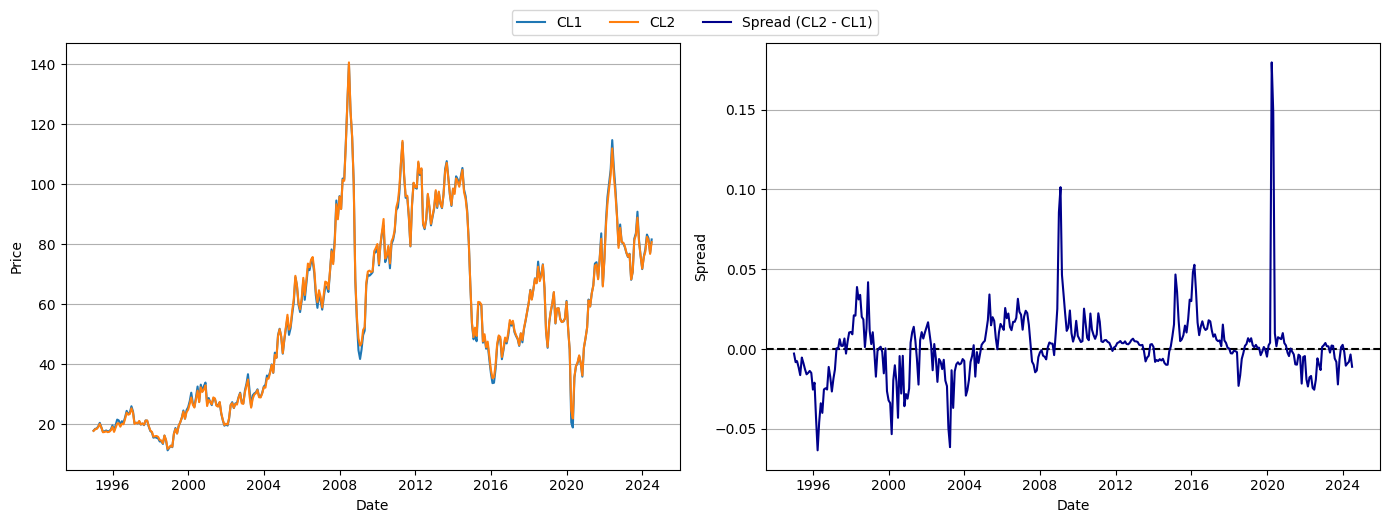

In [17]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Oil Data.xlsx'
industry_monthly_data = pd.read_excel(file_path, sheet_name='Industry_M')
macro_data = pd.read_excel(file_path, sheet_name='Macro_M')
stock_prices = pd.read_excel(file_path, sheet_name='StockPrices_M')

# Create new column for the oil prices spread
industry_monthly_data['Spread'] = np.log(industry_monthly_data['CL2']) - np.log(industry_monthly_data['CL1'])

# Convert date columns into datetime format
industry_monthly_data['Date'] = pd.to_datetime(industry_monthly_data['Date'])
macro_data['Date'] = pd.to_datetime(macro_data['Date'])
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
last_date = industry_monthly_data['Date'].max()

# Converted date frequency into monthly
industry_monthly_data['Date'] = industry_monthly_data['Date'].dt.to_period('M').dt.to_timestamp('M')
macro_data['Date'] = macro_data['Date'].dt.to_period('M').dt.to_timestamp('M')
stock_prices['Date'] = stock_prices['Date'].dt.to_period('M').dt.to_timestamp('M')

# Merged the separate datasets into one large dataset
merged_data = industry_monthly_data.merge(macro_data, on='Date', how='inner')
merged_data = merged_data.merge(stock_prices, on='Date', how='inner')
merged_data = merged_data.sort_values('Date')

# Plot the prices and spread for visualisation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].grid(axis='y')
ax[0].plot(merged_data['Date'], merged_data['CL1'], label="CL1")
ax[0].plot(merged_data['Date'], merged_data['CL2'], label="CL2")
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')

ax[1].grid(axis='y')
ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].plot(merged_data['Date'], merged_data['Spread'], color='darkblue', label='Spread (CL2 - CL1)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Spread')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

plt.tight_layout()

# Drop unneccessary columns
merged_data = merged_data.drop(columns=['CL1', 'CL2', 'Total Open Interest', 'Shell'])

# ADFuller, KPSS, and Granger-Causality tests

In [18]:
# AdFuller test
for i in merged_data:
    if i == "Date":
        continue
    adfullertest = adfuller(merged_data[i].dropna())
    if adfullertest[1] > 0.05:
        merged_data[i] = merged_data[i].diff()
merged_data_adfuller_cleaned = merged_data.dropna()

# KPSS test
for i in merged_data:
    if i == "Date": # Ignore the Date column
        continue
    kpsstest = adfuller(merged_data[i].dropna())
    if kpsstest[1] > 0.05:
        merged_data[i] = merged_data[i].diff()
merged_data_kpss_cleaned = merged_data.dropna()

model_vars = ['Brent', 'CRKS321C Index', 'Baltic Dry Index',
       'Daily Production', 'Inventories', 'Rig Count', 'Commercial Long',
       'Commercial Short', 'Spread', 'CPI YOY %', '3M Yield', '10Y Yield',
       'IndustrialProduction Index', 'SPX', 'DXY returns', 'VIX',
       'Gasoline All Grades', 'Dow Jones US Oil&Gas Index']

# Fit the cleaned data to an initial VAR model to determine the information criteria values
var_data = merged_data_adfuller_cleaned[model_vars]
model = VAR(var_data)
lag_order = model.select_order()
optimal_lag = max(lag_order.aic, lag_order.bic, lag_order.hqic)

# Granger-causality test for significant variables
significant_vars = ['Spread']
p_values_dict = {}

for i in model_vars:
    if i != 'Spread':
        gctest = grangercausalitytests(var_data[['Spread', i]], maxlag=optimal_lag, verbose=False)
        min_p_value = min(gctest[lag][0]['ssr_ftest'][1] for lag in range(1, optimal_lag)) # Get the minimum p-value
        if min_p_value < 0.05:
            p_values_dict[i] = min_p_value
            significant_vars.append(i)

# Print significant results sorted by strength (lowest p-value first)
sorted_p_values = sorted(p_values_dict.items(), key=lambda x: x[1])
for var, p_val in sorted_p_values:
    print(f"{var}: p-value = {p_val:.6f}")

print("Significant variables", significant_vars)

IndustrialProduction Index: p-value = 0.000194
Baltic Dry Index: p-value = 0.000239
3M Yield: p-value = 0.000302
Brent: p-value = 0.000448
Gasoline All Grades: p-value = 0.000822
Dow Jones US Oil&Gas Index: p-value = 0.000940
10Y Yield: p-value = 0.001239
VIX: p-value = 0.001956
SPX: p-value = 0.007020
Inventories: p-value = 0.022039
Daily Production: p-value = 0.047165
Significant variables ['Spread', 'Brent', 'Baltic Dry Index', 'Daily Production', 'Inventories', '3M Yield', '10Y Yield', 'IndustrialProduction Index', 'SPX', 'VIX', 'Gasoline All Grades', 'Dow Jones US Oil&Gas Index']


# Correlation matrix and variable importance

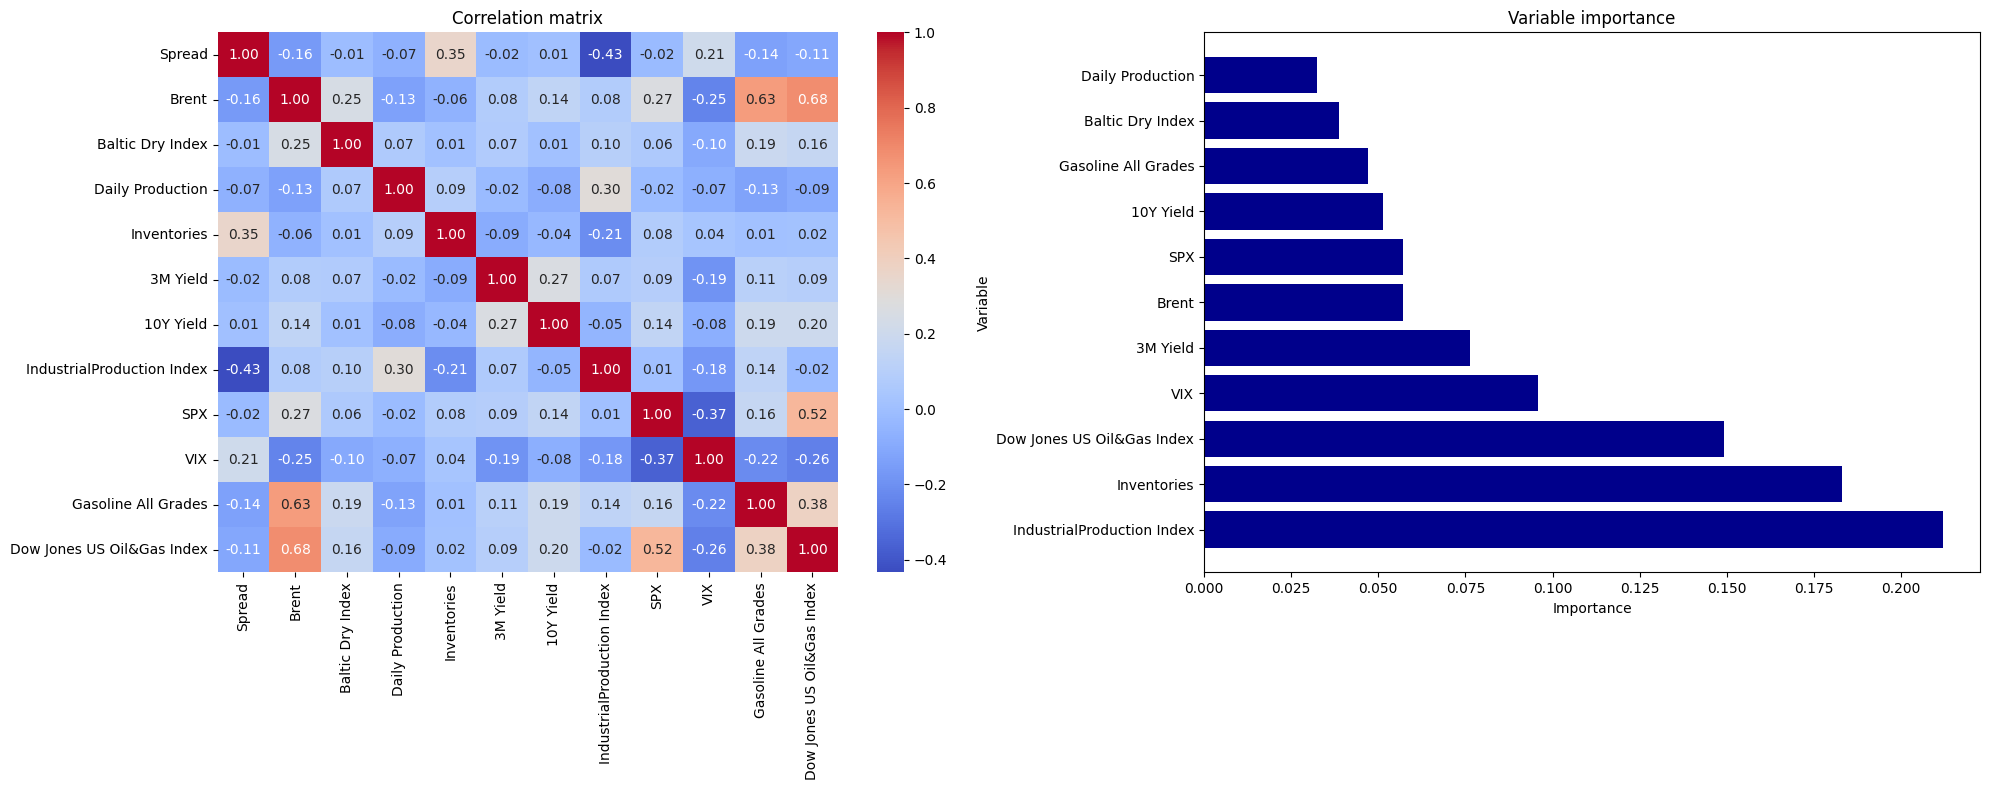

In [19]:
# Prepare RNN data for use later
merged_data_adfuller_cleaned = pd.DataFrame(merged_data_adfuller_cleaned)
rnn_data = merged_data_adfuller_cleaned[significant_vars]
rnn_data.columns = rnn_data.columns.str.strip()
rnn_data.dropna(inplace=True)

# Fit data to sample Random Forest model
X = rnn_data.drop(columns=['Spread']).dropna()
y = rnn_data['Spread'].loc[X.index]
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(rnn_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation matrix")

axes[1].barh(feature_importance['Feature'], feature_importance['Importance'], color='darkblue')
axes[1].set_title("Variable importance")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Variable")

plt.tight_layout()

# Drop unnecessary variables
rnn_data = rnn_data.drop(columns=['Daily Production', 'Gasoline All Grades'])

# Data normalisation

## Brent

In [20]:
variable = 'Brent'

rnn_data[variable] = power_transform(rnn_data[[variable]], method='yeo-johnson')

skewness_val = skew(rnn_data[variable])
kurtosis_val = kurtosis(rnn_data[variable])
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")

Skewness: -0.005555501823683415
Kurtosis: 2.1817202118878614


## Dow Jones US Oil&Gas Index

In [21]:
variable = 'Dow Jones US Oil&Gas Index'

rnn_data[variable] = power_transform(rnn_data[[variable]], method='yeo-johnson')

skewness_val = skew(rnn_data[variable])
kurtosis_val = kurtosis(rnn_data[variable])
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")

Skewness: 0.13037275596490416
Kurtosis: 2.9144800804646565


## 3M Yield

In [22]:
variable = '3M Yield'

rnn_data[variable] = power_transform(rnn_data[[variable]], method='yeo-johnson')

rnn_data[variable] = winsorize(rnn_data[variable], limits=[0.01, 0.01])

skewness_val = skew(rnn_data[variable])
kurtosis_val = kurtosis(rnn_data[variable])
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")

Skewness: 0.11432983802861423
Kurtosis: 5.152626290052204


## 10Y Yield

In [23]:
variable = '10Y Yield'

rnn_data[variable] = power_transform(rnn_data[[variable]], method='yeo-johnson')

skewness_val = skew(rnn_data[variable])
kurtosis_val = kurtosis(rnn_data[variable])
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")

Skewness: -0.000948091368561385
Kurtosis: 0.7358517150667687


## IndustrialProduction Index

In [24]:
variable = 'IndustrialProduction Index'

rnn_data[variable] = power_transform(rnn_data[[variable]], method='yeo-johnson')

rnn_data[variable] = winsorize(rnn_data[variable], limits=[0.01, 0.01])

skewness_val = skew(rnn_data[variable])
kurtosis_val = kurtosis(rnn_data[variable])
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")

Skewness: -0.518991678513166
Kurtosis: 3.022592775484899


## SPX

In [25]:
variable = 'SPX'

rnn_data[variable] = power_transform(rnn_data[[variable]], method='yeo-johnson')

rnn_data[variable] = winsorize(rnn_data[variable], limits=[0.01, 0.01])

skewness_val = skew(rnn_data[variable])
kurtosis_val = kurtosis(rnn_data[variable])
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")

Skewness: 0.3669275734600803
Kurtosis: 3.176416688865581


## Baltic Dry Index

In [26]:
variable = 'Baltic Dry Index'

rnn_data[variable] = power_transform(rnn_data[[variable]], method='yeo-johnson')

rnn_data[variable] = winsorize(rnn_data[variable], limits=[0.01, 0.01])

skewness_val = skew(rnn_data[variable])
kurtosis_val = kurtosis(rnn_data[variable])
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")

Skewness: 0.3936530865865564
Kurtosis: 3.209413081146306


# RNN model

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 1.5540 - val_loss: 3.0306
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.9089 - val_loss: 2.8650
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.7827 - val_loss: 2.8986
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.7881 - val_loss: 2.9568
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.7137 - val_loss: 2.9460
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.7109 - val_loss: 3.7403
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.7345 - val_loss: 3.0879
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6420 - val_loss: 2.9771
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6353 - val_loss: 3.0313
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.4266 - val_loss: 3.1966
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.3897 - val_loss: 3.3635
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/st

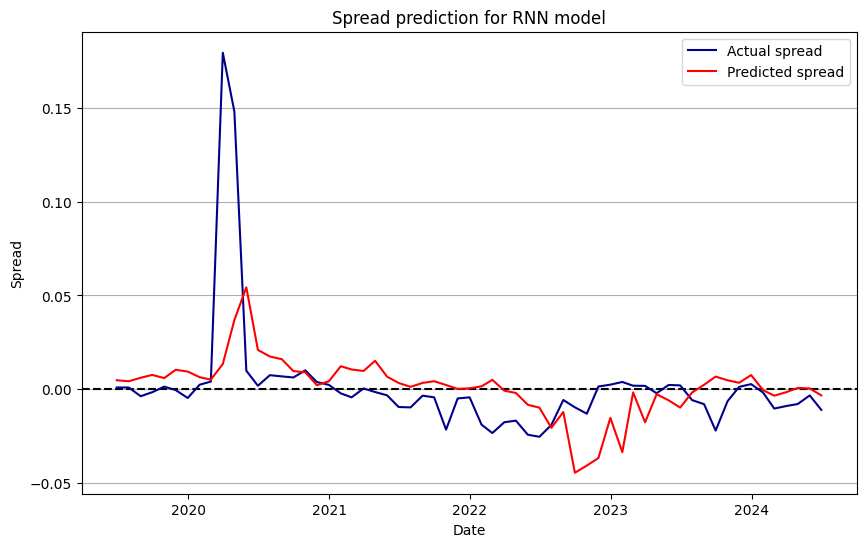

In [27]:
# Set random seed for reproducibility
tf.keras.utils.set_random_seed(150)
tf.config.experimental.enable_op_determinism()

# Add a lag column (lag all data by 1 time step)
def add_lag_features(df, lag_columns, num_lags=3):
    for col in lag_columns:
        for lag in range(1, num_lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df
lag_columns = rnn_data.columns
rnn_data = add_lag_features(rnn_data, lag_columns, num_lags=1)

# Define independent and dependent variables
rnn_data = rnn_data.dropna()
rnn_features = rnn_data.drop(columns=['Spread']) # Drop spread column in the independent variable set
rnn_target = rnn_data['Spread']

# RobustScaler used to transform variables into comparable scales and reduce outliers
scaler_x = RobustScaler()
scaler_y = RobustScaler()
rnn_features_scaled = scaler_x.fit_transform(rnn_features)
rnn_target_scaled = scaler_y.fit_transform(rnn_target.values.reshape(-1, 1))

# Split the data into in-sample and  out-of-sample
split_index = int(len(rnn_features) * 0.8) # 80-20 split
X_train, X_test = rnn_features_scaled[:split_index], rnn_features_scaled[split_index:]
y_train, y_test = rnn_target_scaled[:split_index], rnn_target_scaled[split_index:]

# Lookback window size creation
def create_sequences(X, y, seq_length=10):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)
seq_length = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

# Reshape so the inputs are the same size to prevent error
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

# Define the network
model = Sequential([
    LSTM(256, activation='tanh', return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])),
    Dropout(0.3),
    LSTM(128, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_data=(X_test_seq, y_test_seq), verbose=1, shuffle=False)

# Out-of-sample loss
loss = model.evaluate(X_test_seq, y_test_seq)
print(f"Out-of-sample loss: {loss:.4f}")

# Make predictions
y_pred_scaled = model.predict(X_test_seq)

# Convert back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Accuracy metrics
r_squared = r2_score(y_test_actual, y_pred)
print(f'R-squared: {r_squared:.3f}')
mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error (MSE): {mse:.3f}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

# Compute residuals
residuals = y_test_actual - y_pred

plt.figure(figsize=(10, 6))
plt.grid(axis='y')
plt.axhline(y = 0, color='black', linestyle='--')
plt.plot(merged_data_kpss_cleaned['Date'].iloc[-len(y_test_actual):], y_test_actual, label="Actual spread", color='darkblue')
plt.plot(merged_data_kpss_cleaned['Date'].iloc[-len(y_pred):], y_pred, label="Predicted spread", color='red')
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.title("Spread prediction for RNN model")

# Residual plots (incl. outliers)

Text(0.5, 1.0, 'Autocorrelation of residuals')

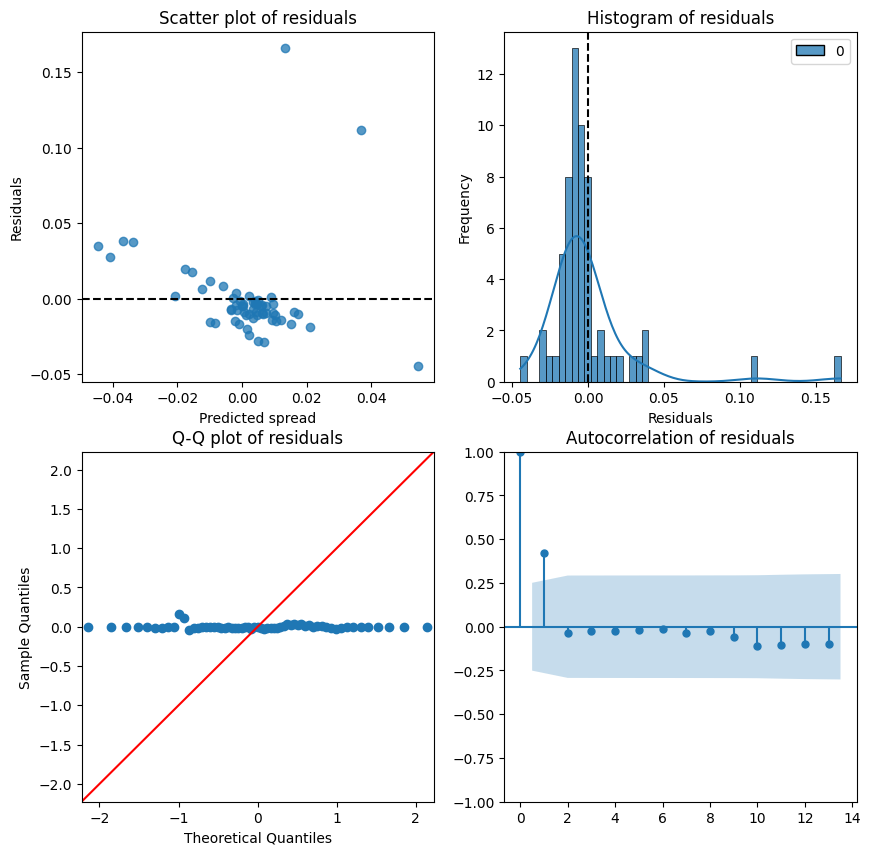

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plot
ax[0, 0].scatter(y_pred, residuals, alpha=0.75)
ax[0, 0].axhline(y=0, color='black', linestyle='--')
ax[0, 0].set_xlabel('Predicted spread')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Scatter plot of residuals')

# Histogram of residuals
sns.histplot(residuals, kde=True, bins=50, alpha=0.75, edgecolor='black', ax=ax[0, 1])
ax[0, 1].axvline(x=0, color='black', linestyle='--')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Histogram of residuals')

# Q-Q Plot of residuals
sm.qqplot(residuals, line='45', ax=ax[1, 0])
ax[1, 0].set_title('Q-Q plot of residuals')

# Autocorrelation of residuals
plot_acf(residuals, lags=13, ax=ax[1, 1])
ax[1, 1].set_title('Autocorrelation of residuals')

# Residual plots (excl. outliers)

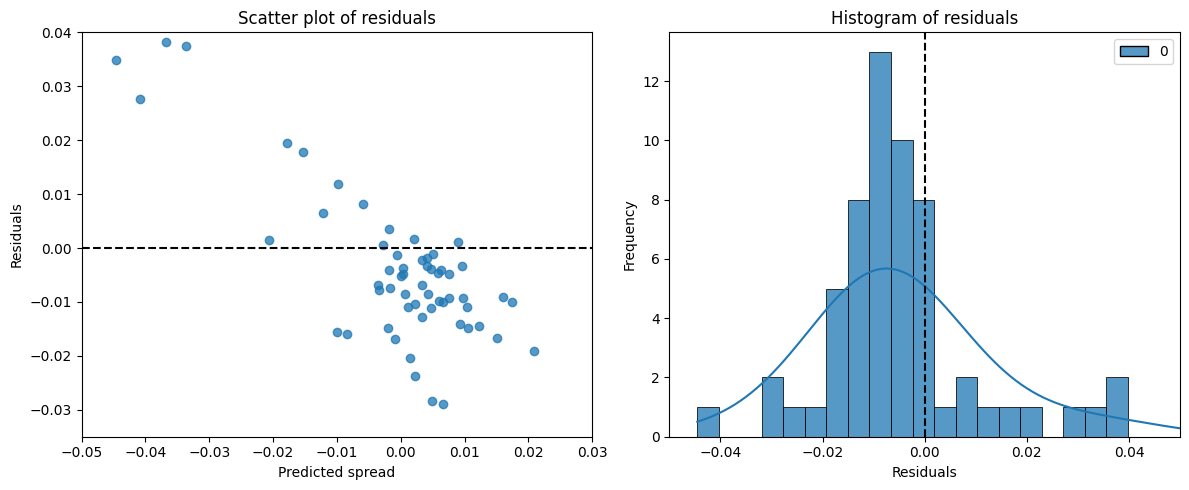

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
ax[0].scatter(y_pred, residuals, alpha=0.75)
ax[0].axhline(y=0, color='black', linestyle='--')
ax[0].set_xlabel('Predicted spread')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Scatter plot of residuals')
ax[0].set_xlim(-0.05, 0.03)
ax[0].set_ylim(-0.035, 0.04)

# Histogram of residuals
sns.histplot(residuals, kde=True, bins=50, alpha=0.75, edgecolor='black', ax=ax[1])
ax[1].axvline(x=0, color='black', linestyle='--')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of residuals')
ax[1].set_xlim(-0.05, 0.05)

plt.tight_layout()

# 12-month forecast

Text(0.5, 1.0, '12-month spread prediction forecast for RNN model')

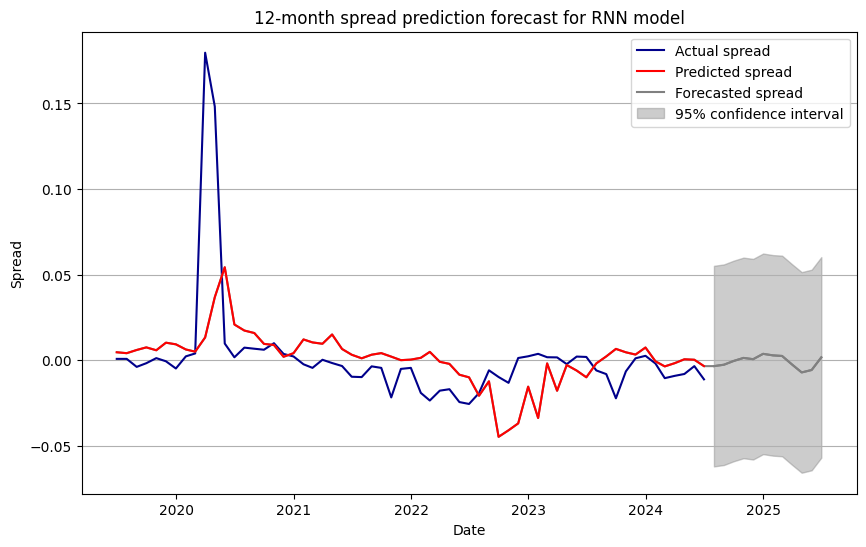

In [30]:
forecast_period = 12
last_sequence = X_test_seq[-1] # Get the last sequence from test data

# Forecast predictions and standard deviation arrays
forecast_predictions = []
forecast_std_dev = []

for _ in range(forecast_period):
    last_sequence_reshaped = last_sequence.reshape((1, seq_length, X_train_seq.shape[2])) # Reshape last sequence to fit the input
    next_pred_scaled = model.predict(last_sequence_reshaped, verbose=0) # Predict next value
    next_pred = scaler_y.inverse_transform(next_pred_scaled)[0, 0] # Inverse transform the prediction
    # Save prediction to arrays
    forecast_predictions.append(next_pred)
    forecast_std_dev.append(np.std(next_pred_scaled))
    new_pred_reshaped = np.full((1, last_sequence.shape[1]), next_pred_scaled[0, 0]) # Reshape predicted value to fit the next input
    last_sequence = np.vstack((last_sequence[1:], new_pred_reshaped)) # Update last_sequence, remove first time step and append new prediction

# Generate forecast dates
last_date = merged_data_kpss_cleaned['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_period + 1, freq='M')[1:]

# Standard deviations
residual_std_dev = np.std(y_test_actual - y_pred)
forecast_std_dev = np.full(forecast_period, residual_std_dev)

# Create dataframe to plot
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Spread': forecast_predictions})

# Comput 95% confidence interval
z = norm.ppf(0.975)
forecast_df['Lower Bound'] = forecast_df['Forecasted Spread'] - (z * forecast_std_dev)
forecast_df['Upper Bound'] = forecast_df['Forecasted Spread'] + (z * forecast_std_dev)

# Create a combined dataframe of the prediction and forecast to plot
combined_predictions = np.concatenate([y_pred.flatten(), np.array(forecast_predictions)])
combined_dates = pd.concat([merged_data_kpss_cleaned['Date'].iloc[-len(y_pred):], forecast_df['Date']]).reset_index(drop=True)
combined_df = pd.DataFrame({'Date': combined_dates, 'Predicted Spread': combined_predictions}).sort_values('Date').reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.grid(axis='y')

# Plot historical actual and predicted data
plt.plot(merged_data_kpss_cleaned['Date'].iloc[-len(y_test_actual):], y_test_actual, label="Actual spread", color='darkblue')
plt.plot(combined_dates, combined_predictions, color='grey')
plt.plot(merged_data_kpss_cleaned['Date'].iloc[-len(y_pred):], y_pred, label="Predicted spread", color='red')

# Plot future forecast
plt.plot(forecast_df['Date'], forecast_df['Forecasted Spread'], label="Forecasted spread", color='grey')
plt.fill_between(forecast_df['Date'], forecast_df['Lower Bound'], forecast_df['Upper Bound'], color='grey', alpha=0.4, label='95% confidence interval')

plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.title("12-month spread prediction forecast for RNN model")